In [876]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from collections import Counter

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

sns.set(style='white', context='notebook', palette='deep')

In [865]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
IDtest = test["PassengerId"]
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [866]:
# Outlier detection 

def detect_outliers(df,n,features):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according
    to the Tukey method.
    """
    outlier_indices = []
    
    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    
    return multiple_outliers   

# detect outliers from Age, SibSp , Parch and Fare
Outliers_to_drop = detect_outliers(train,2,["Age","SibSp","Parch","Fare"])

C:\Users\kandibkooe\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\lib\function_base.py:3652: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


In [867]:
train.loc[Outliers_to_drop]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


In [868]:
train = train.drop(Outliers_to_drop, axis = 0).reset_index(drop=True)

In [869]:
train_len = len(train)
dataset =  pd.concat(objs=[train, test], axis=0).reset_index(drop=True)
# Fill empty and NaNs values with NaN
dataset = dataset.fillna(np.nan)

# Check for Null values
dataset.isnull().sum()

C:\Users\kandibkooe\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


Age             256
Cabin          1007
Embarked          2
Fare              1
Name              0
Parch             0
PassengerId       0
Pclass            0
Sex               0
SibSp             0
Survived        418
Ticket            0
dtype: int64

In [870]:
# convert Sex into categorical value 0 for male and 1 for female
dataset["Sex"] = dataset["Sex"].map({"male": 0, "female":1})

In [871]:
# Apply log to Fare to reduce skewness distribution
dataset["Fare"] = dataset["Fare"].map(lambda i: np.log(i) if i > 0 else 0)

In [872]:
#Fill Embarked nan values of dataset set with 'S' most frequent value
dataset["Embarked"] = dataset["Embarked"].fillna("S")

In [873]:
#fill Age with the median age of similar rows according to Pclass, Parch and SibSp

index_NaN_age = list(dataset["Age"][dataset["Age"].isnull()].index)

for i in index_NaN_age :
    age_med = dataset["Age"].median()
    age_pred = dataset["Age"][((dataset['SibSp'] == dataset.iloc[i]["SibSp"]) & (dataset['Parch'] == dataset.iloc[i]["Parch"]) & (dataset['Pclass'] == dataset.iloc[i]["Pclass"]))].median()
    if not np.isnan(age_pred) :
        dataset['Age'].iloc[i] = age_pred
    else :
        dataset['Age'].iloc[i] = age_med

C:\Users\kandibkooe\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [877]:
dataset["Name"].head()
dataset_title = [i.split(",")[1].split(".")[0].strip() for i in dataset["Name"]]
dataset["Title"] = pd.Series(dataset_title)
dataset["Title"].head()

0      Mr
1     Mrs
2    Miss
3     Mrs
4      Mr
Name: Title, dtype: object

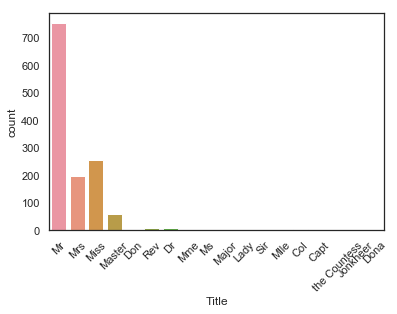

In [878]:
g = sns.countplot(x="Title",data=dataset)
g = plt.setp(g.get_xticklabels(), rotation=45) 

In [879]:
# Convert to categorical values Title 
dataset["Title"] = dataset["Title"].replace(['Lady', 'the Countess','Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
dataset["Title"] = dataset["Title"].map({"Master":0, "Miss":1, "Ms" : 1 , "Mme":1, "Mlle":1, "Mrs":1, "Mr":2, "Rare":3})
dataset["Title"] = dataset["Title"].astype(int)

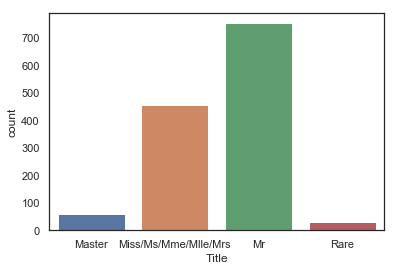

In [880]:
g = sns.countplot(dataset["Title"])
g = g.set_xticklabels(["Master","Miss/Ms/Mme/Mlle/Mrs","Mr","Rare"])

C:\Users\kandibkooe\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\kandibkooe\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


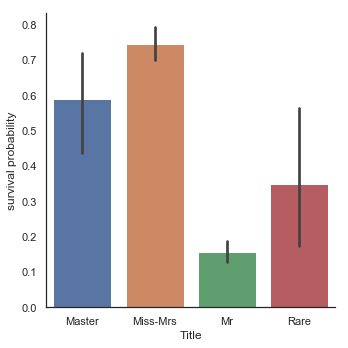

In [881]:
g = sns.factorplot(x="Title",y="Survived",data=dataset,kind="bar")
g = g.set_xticklabels(["Master","Miss-Mrs","Mr","Rare"])
g = g.set_ylabels("survival probability")

In [882]:
dataset.drop(labels = ["Name"], axis = 1, inplace = True)

C:\Users\kandibkooe\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


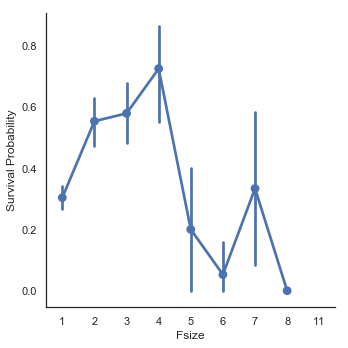

In [883]:
dataset["Fsize"] = dataset["SibSp"] + dataset["Parch"] + 1
g = sns.factorplot(x="Fsize",y="Survived",data = dataset)
g = g.set_ylabels("Survival Probability")

In [884]:
# Create new feature of family size
dataset['Single'] = dataset['Fsize'].map(lambda s: 1 if s == 1 else 0)
dataset['SmallF'] = dataset['Fsize'].map(lambda s: 1 if  s == 2  else 0)
dataset['MedF'] = dataset['Fsize'].map(lambda s: 1 if 3 <= s <= 4 else 0)
dataset['LargeF'] = dataset['Fsize'].map(lambda s: 1 if s >= 5 else 0)

C:\Users\kandibkooe\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\kandibkooe\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\kandibkooe\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the defau

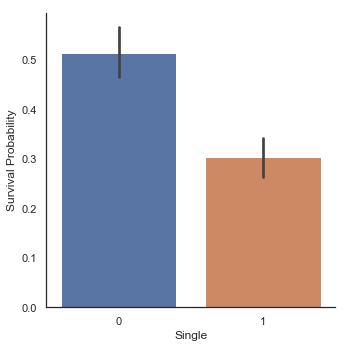

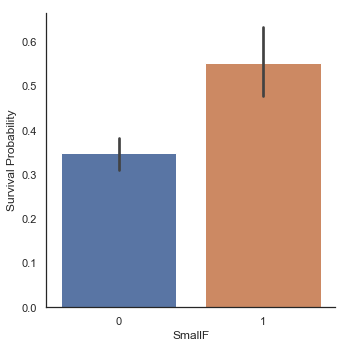

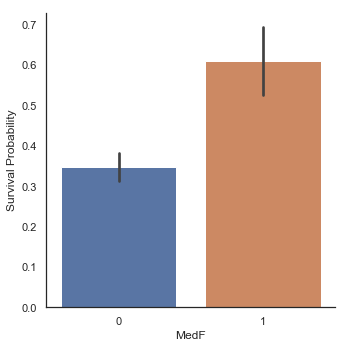

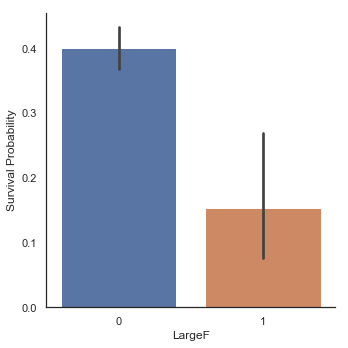

In [885]:
g = sns.factorplot(x="Single",y="Survived",data=dataset,kind="bar")
g = g.set_ylabels("Survival Probability")
g = sns.factorplot(x="SmallF",y="Survived",data=dataset,kind="bar")
g = g.set_ylabels("Survival Probability")
g = sns.factorplot(x="MedF",y="Survived",data=dataset,kind="bar")
g = g.set_ylabels("Survival Probability")
g = sns.factorplot(x="LargeF",y="Survived",data=dataset,kind="bar")
g = g.set_ylabels("Survival Probability")

In [886]:
# convert to indicator values Title and Embarked 
dataset = pd.get_dummies(dataset, columns = ["Title"])
dataset = pd.get_dummies(dataset, columns = ["Embarked"], prefix="Em")

In [887]:
train = dataset[:train_len]
test = dataset[train_len:]
test.drop(labels=["Survived"],axis = 1,inplace=True)

C:\Users\kandibkooe\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [888]:
test.head()

,Age,Cabin,Fare,Parch,PassengerId,Pclass,Sex,SibSp,Ticket,Fsize,...,SmallF,MedF,LargeF,Title_0,Title_1,Title_2,Title_3,Em_C,Em_Q,Em_S
881,34.5,NaN,2.057860,0,892,3,0,0,330911,1,...,0,0,0,0,0,1,0,0,1,0
882,47.0,NaN,1.945910,0,893,3,1,1,363272,2,...,1,0,0,0,1,0,0,0,0,1
883,62.0,NaN,2.270836,0,894,2,0,0,240276,1,...,0,0,0,0,0,1,0,0,1,0
884,27.0,NaN,2.159003,0,895,3,0,0,315154,1,...,0,0,0,0,0,1,0,0,0,1
885,22.0,NaN,2.508582,1,896,3,1,1,3101298,3,...,0,1,0,0,1,0,0,0,0,1


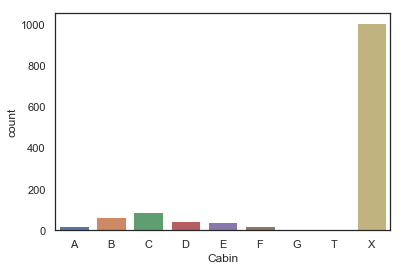

In [889]:
dataset["Cabin"].head()
# Replace the Cabin number by the type of cabin 'X' if not
dataset["Cabin"] = pd.Series([i[0] if not pd.isnull(i) else 'X' for i in dataset['Cabin'] ])
g = sns.countplot(dataset["Cabin"],order=['A','B','C','D','E','F','G','T','X'])

C:\Users\kandibkooe\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


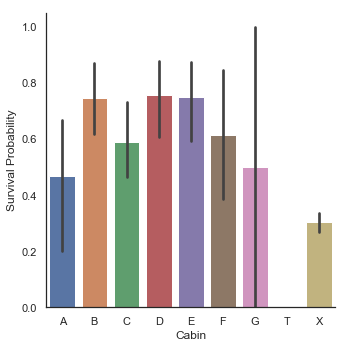

In [890]:
g = sns.factorplot(y="Survived",x="Cabin",data=dataset,kind="bar",order=['A','B','C','D','E','F','G','T','X'])
g = g.set_ylabels("Survival Probability")

In [892]:
dataset = pd.get_dummies(dataset, columns = ["Cabin"],prefix="Cabin")

In [893]:
dataset["Ticket"].head()

0           A/5 21171
1            PC 17599
2    STON/O2. 3101282
3              113803
4              373450
Name: Ticket, dtype: object

In [894]:
## Treat Ticket by extracting the ticket prefix. When there is no prefix it returns X. 

Ticket = []
for i in list(dataset.Ticket):
    if not i.isdigit() :
        Ticket.append(i.replace(".","").replace("/","").strip().split(' ')[0]) #Take prefix
    else:
        Ticket.append("X")
        
dataset["Ticket"] = Ticket
dataset["Ticket"].head()

0        A5
1        PC
2    STONO2
3         X
4         X
Name: Ticket, dtype: object

In [895]:
dataset = pd.get_dummies(dataset, columns = ["Ticket"], prefix="T")

In [896]:
# Create categorical values for Pclass
dataset["Pclass"] = dataset["Pclass"].astype("category")
dataset = pd.get_dummies(dataset, columns = ["Pclass"],prefix="Pc")

In [897]:
dataset.drop(labels = ["PassengerId"], axis = 1, inplace = True)

In [898]:
dataset.head()

,Age,Fare,Parch,Sex,SibSp,Survived,Fsize,Single,SmallF,MedF,...,T_STONO,T_STONO2,T_STONOQ,T_SWPP,T_WC,T_WEP,T_X,Pc_1,Pc_2,Pc_3
0,22.0,1.981001,0,0,1,0.0,2,0,1,0,...,0,0,0,0,0,0,0,0,0,1
1,38.0,4.266662,0,1,1,1.0,2,0,1,0,...,0,0,0,0,0,0,0,1,0,0
2,26.0,2.070022,0,1,0,1.0,1,1,0,0,...,0,1,0,0,0,0,0,0,0,1
3,35.0,3.972177,0,1,1,1.0,2,0,1,0,...,0,0,0,0,0,0,1,1,0,0
4,35.0,2.085672,0,0,0,0.0,1,1,0,0,...,0,0,0,0,0,0,1,0,0,1


In [899]:
## Separate train dataset and test dataset

train = dataset[:train_len]
test = dataset[train_len:]
test.drop(labels=["Survived"],axis = 1,inplace=True)

In [900]:
train["Survived"] = train["Survived"].astype(int)

Y_train = train["Survived"]

X_train = train.drop(labels = ["Survived"],axis = 1)

C:\Users\kandibkooe\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [901]:
kfold = StratifiedKFold(n_splits=10)

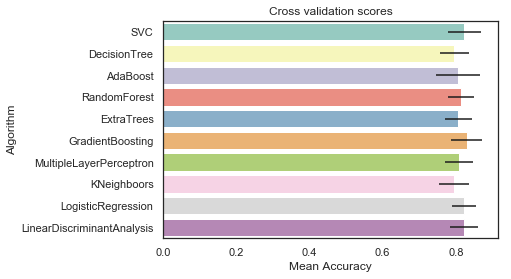

In [902]:
random_state = 2
classifiers = []
classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state = random_state))
classifiers.append(LinearDiscriminantAnalysis())

cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, X_train, y = Y_train, scoring = "accuracy", cv = kfold, n_jobs=4))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["SVC","DecisionTree","AdaBoost",
"RandomForest","ExtraTrees","GradientBoosting","MultipleLayerPerceptron","KNeighboors","LogisticRegression","LinearDiscriminantAnalysis"]})

g = sns.barplot("CrossValMeans","Algorithm",data = cv_res, palette="Set3",orient = "h",**{'xerr':cv_std})
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross validation scores")

In [909]:
### META MODELING  WITH ADABOOST, RF, EXTRATREES and GRADIENTBOOSTING

# Adaboost
DTC = DecisionTreeClassifier()

adaDTC = AdaBoostClassifier(DTC, random_state=7)

ada_param_grid = {"base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter" :   ["best", "random"],
              "algorithm" : ["SAMME","SAMME.R"],
              "n_estimators" :[1,2,3,4,5],
              "learning_rate":  [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3,1.5,2]}

gsadaDTC = GridSearchCV(adaDTC,param_grid = ada_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsadaDTC.fit(X_train,Y_train)

ada_best = gsadaDTC.best_estimator_
gsadaDTC.best_params_

Fitting 10 folds for each of 320 candidates, totalling 3200 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 348 tasks      | elapsed:    3.1s
[Parallel(n_jobs=4)]: Done 1848 tasks      | elapsed:   17.1s
[Parallel(n_jobs=4)]: Done 3200 out of 3200 | elapsed:   30.9s finished


{'algorithm': 'SAMME.R',
 'base_estimator__criterion': 'entropy',
 'base_estimator__splitter': 'best',
 'learning_rate': 0.2,
 'n_estimators': 4}

In [908]:
gsadaDTC.best_score_

0.8263337116912599

In [ ]:
#ExtraTrees 
ExtC = ExtraTreesClassifier()


## Search grid for optimal parameters
ex_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 5, 7, 9, 10],
              "min_samples_split": [2, 3, 5, 7, 9, 10],
              "min_samples_leaf": [1, 3, 5, 7, 9, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300,500,1000],
              "criterion": ["gini","entropy"]}


gsExtC = GridSearchCV(ExtC,param_grid = ex_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsExtC.fit(X_train,Y_train)

ExtC_best = gsExtC.best_estimator_

# Best score
gsExtC.best_params_

Fitting 10 folds for each of 1728 candidates, totalling 17280 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   18.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  1.3min
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  2.3min
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:  3.3min
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:  4.6min
[Parallel(n_jobs=4)]: Done 1792 tasks      | elapsed:  6.8min
[Parallel(n_jobs=4)]: Done 2442 tasks      | elapsed:  9.0min
[Parallel(n_jobs=4)]: Done 3192 tasks      | elapsed: 12.0min
[Parallel(n_jobs=4)]: Done 4042 tasks      | elapsed: 15.0min
[Parallel(n_jobs=4)]: Done 4992 tasks      | elapsed: 19.0min
[Parallel(n_jobs=4)]: Done 6042 tasks      | elapsed: 23.4min
[Parallel(n_jobs=4)]: Done 7192 tasks      | elapsed: 28.2min
[Parallel(n_jobs=4)]: Done 8442 tasks      | elapsed: 33.8min
[Parallel(n_jobs=4)]: Done 9792 tasks      | elapsed: 38.6min
[Parallel(n_jobs=4)]: Done 11242 tasks      | elapsed: 43.7mi

In [ ]:
gsExtC.best_score_

In [798]:
# RFC Parameters tunning 
RFC = RandomForestClassifier()


## Search grid for optimal parameters
rf_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}


gsRFC = GridSearchCV(RFC,param_grid = rf_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsRFC.fit(X_train,Y_train)

RFC_best = gsRFC.best_estimator_

# Best score
gsRFC.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  54 tasks      | elapsed:   10.6s
[Parallel(n_jobs=4)]: Done 204 tasks      | elapsed:   27.2s
[Parallel(n_jobs=4)]: Done 454 tasks      | elapsed:  1.1min
[Parallel(n_jobs=4)]: Done 540 out of 540 | elapsed:  1.3min finished


0.8297389330306469

In [799]:
# Gradient boosting tunning

GBC = GradientBoostingClassifier()
gb_param_grid = {'loss' : ["deviance"],
              'n_estimators' : [100,200,300],
              'learning_rate': [0.1, 0.05, 0.01],
              'max_depth': [4, 8],
              'min_samples_leaf': [100,150],
              'max_features': [0.3, 0.1] 
              }

gsGBC = GridSearchCV(GBC,param_grid = gb_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsGBC.fit(X_train,Y_train)

GBC_best = gsGBC.best_estimator_

# Best score
gsGBC.best_score_

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 10 folds for each of 72 candidates, totalling 720 fits


[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    5.4s
[Parallel(n_jobs=4)]: Done 376 tasks      | elapsed:   23.2s
[Parallel(n_jobs=4)]: Done 720 out of 720 | elapsed:   43.8s finished


0.8308740068104427

In [800]:
### SVC classifier
SVMC = SVC(probability=True)
svc_param_grid = {'kernel': ['rbf'], 
                  'gamma': [ 0.001, 0.01, 0.1, 1],
                  'C': [1, 10, 50, 100,200,300, 1000]}

gsSVMC = GridSearchCV(SVMC,param_grid = svc_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsSVMC.fit(X_train,Y_train)

SVMC_best = gsSVMC.best_estimator_

# Best score
gsSVMC.best_score_

Fitting 10 folds for each of 28 candidates, totalling 280 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    9.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   47.0s
[Parallel(n_jobs=4)]: Done 280 out of 280 | elapsed:  1.4min finished


0.8217934165720772

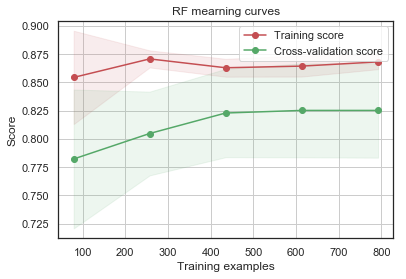

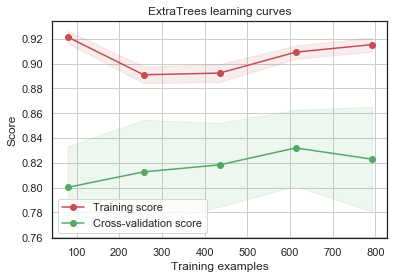

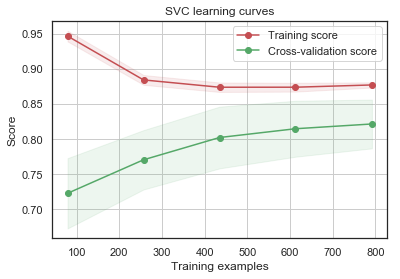

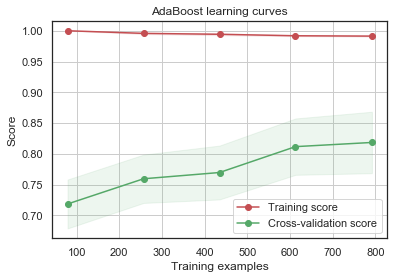

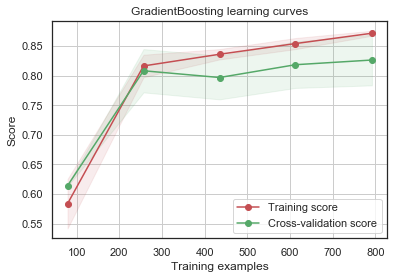

In [801]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

g = plot_learning_curve(gsRFC.best_estimator_,"RF mearning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsExtC.best_estimator_,"ExtraTrees learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsSVMC.best_estimator_,"SVC learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsadaDTC.best_estimator_,"AdaBoost learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsGBC.best_estimator_,"GradientBoosting learning curves",X_train,Y_train,cv=kfold)

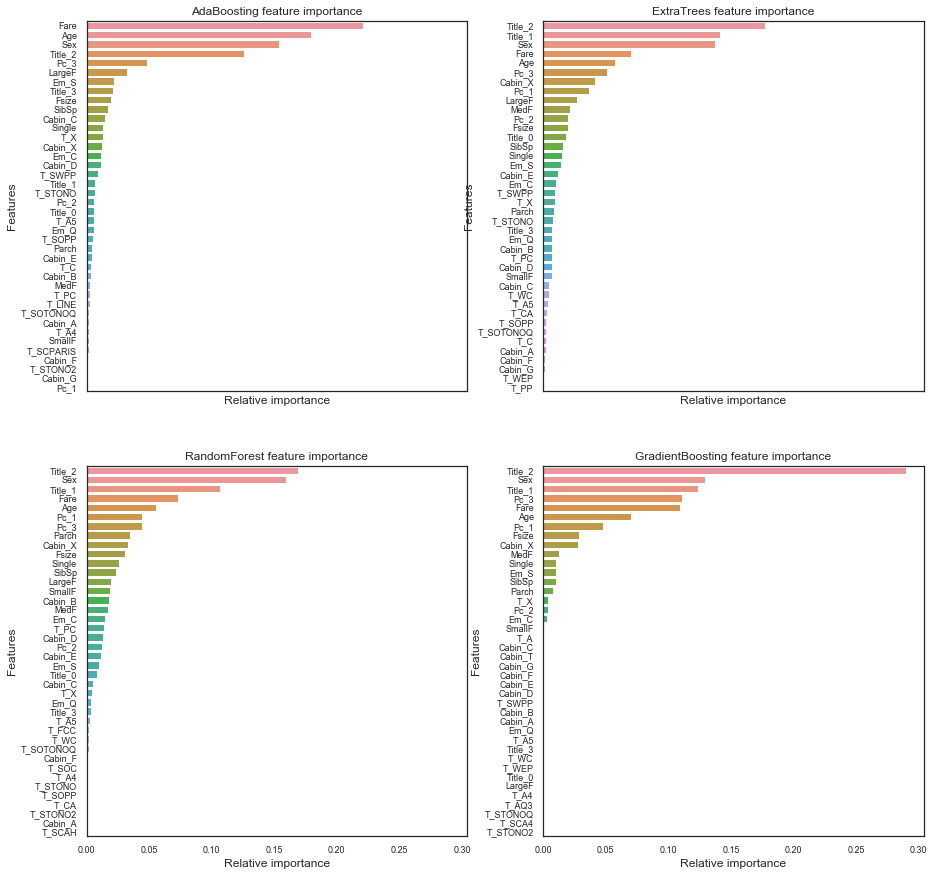

In [802]:
nrows = ncols = 2
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, sharex="all", figsize=(15,15))

names_classifiers = [("AdaBoosting", ada_best),("ExtraTrees",ExtC_best),("RandomForest",RFC_best),("GradientBoosting",GBC_best)]

nclassifier = 0
for row in range(nrows):
    for col in range(ncols):
        name = names_classifiers[nclassifier][0]
        classifier = names_classifiers[nclassifier][1]
        indices = np.argsort(classifier.feature_importances_)[::-1][:40]
        g = sns.barplot(y=X_train.columns[indices][:40],x = classifier.feature_importances_[indices][:40] , orient='h',ax=axes[row][col])
        g.set_xlabel("Relative importance",fontsize=12)
        g.set_ylabel("Features",fontsize=12)
        g.tick_params(labelsize=9)
        g.set_title(name + " feature importance")
        nclassifier += 1

In [838]:
votingC = VotingClassifier(estimators=[('rfc', RFC_best), ('extc', ExtC_best),
('svc', SVMC_best), ('adac',ada_best),('gbc',GBC_best)], voting='soft', n_jobs=4)

votingC.fit(X_train, Y_train)

VotingClassifier(estimators=[('rfc', RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=None, max_features=3, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=2,
            min_weigh...    subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False))],
         flatten_transform=None, n_jobs=4, voting='soft', weights=None)

In [861]:
np.where(np.isnan(test))
test = np.nan_to_num(test)

In [862]:
votingC = votingC.fit(X_train, Y_train)
votingC.predict(test)

array([0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0,
       0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1,
       0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [863]:
test_Survived = pd.Series(votingC.predict(test), name="Survived")

results = pd.concat([IDtest,test_Survived],axis=1)

results.to_csv("ensemble_python_voting.csv",index=False)